In [2]:
import keras
import pandas as pd
from glob import glob                                # Parcourir dossier de dataset
import matplotlib.pyplot as plt
import cv2                                           # traitement des images du dataset
from keras.datasets import mnist                     # Importe le dataset de mnist
from keras.utils import to_categorical               # pour modifier les labels
from keras.models import Sequential, load_model      # type de modele
from keras.layers import Dense, Flatten              # Fully Connected Layers
from keras.layers import Conv2D, MaxPooling2D        # Convolutional layers + Maxpooling layers
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy    # Loss function

# from keras.callbacks import TensorBoard

import h5py                                          # Pour pouvoir enregistrer son modele en .h5

Using TensorFlow backend.


# Detection of handwritten digits with MNIST

MNIST est un exemple très souvent utilisé pour commencer avec les CNN, son dataset existe sur keras et peut être directement importé avec la fonction **load_data( )**

Note :
- Le dataset de MNIST a 60 000 exemples d'entrainement et 10 000 exemples de training
- Le format de chaque image est de 28x28 pixels

## STEP 1 : Load data

In [3]:
# Les données sont déjà séparées en training set et testing set sur keras

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


Vous pouvez voir à quoi ressemble votre dataset avec un print. A noter que votre x_train est une liste [ ] de 60 000 exemples et que votre x_test est une liste de 10 000 exemples

In [6]:
print ('=== x_train ===')
print (x_train)
print ('\n=== y_train ===')
print (y_train)

=== x_train ===
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
(60000, 28, 28)

=== y_train ===
[5 0 4 ... 5 6 8]
(60000,)


- Chaque exemple se compose de 28 listes de 28 valeurs (car 28x28 pixels), il y a donc 28x28 = 784 valeurs, une par pixel
- Chaque pixel a une valeur comprise entre 0 et 255, car un int = 8 octets donc 2^8 = 256 valeurs possibles, mais on commence à zéro donc 0-255
- Les labels sont une valeur unique comprise entre 0 et 9 et correspondent au digit de l'image en question  
  
Vous pouvez verifier la shape de votre dataset (x_train, x_test, y_train et y_test)

In [9]:
print ('x_train:', x_train.shape)
print ('y_train:', y_train.shape)
print ('x_test:', x_test.shape)
print ('y_test:', y_test.shape)

x_train: (60000, 28, 28)
y_train: (60000,)
x_test: (10000, 28, 28)
y_test: (10000,)


## STEP 2 : Prepare Data


Ensuite, une fois les données importées, nous devons les préparer afin qu'elles puissent être données à notre modèle  
Dans un premier temps, nous allons ajouter une dimension à la fin de nos x_train et x_test pour préciser le nombre de canaux que nous utiliserons grâce à la fonction **.reshape( )**

- 1 pour Noir et Blanc
- 3 pour RGB
- L pour nuances de gris

Pour cet exemple, nous nous contenterons d'une image en N&B, donc la valeur de notre dimension supplémentaire sera égale à 1

In [10]:
x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)

Nous allons ensuite normaliser notre dataset afin que les valeurs de nos pixels soient comprises entre 0 et 1 plutôt qu'entre 0 et 255. Cela facilitera les calculs pour la machine.

Pour ce faire, il faudra d'abord "recaster" nos variables *x_train* et *x_test* en tant que float.

In [12]:
# Recast

x_train = x_train.astype(float)
x_test = x_test.astype(float)

# Normalize

x_train /= 255
x_test /= 255

Maintenant qu'on a bien modifié nos training et testing sets, il nous reste à modifier nos labels de façon à ce que la machine puisse mieux les comprendre.

Pour l'instant, notre y_train est une liste de 60 000 valeurs entre 0 et 9, qui sont les labels des images correspondantes. 

*y_train[8] = label de la 9ème image de notre dataset, x_train[8]*

Plutôt que d'avoir un label qui soit une valeur comprise entre 0 et 9, on va préférer avoir un label qui a la forme d'un one-hot vecteur. C'est à dire un vecteur composé de 10 valeurs (0 ou 1), avec un 1 a la position correspondante au label, et des 0 partout ailleurs.

*Exemple : on veut transformer un* **y_train[8] = 1** en **y_train[8] = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]**

On va utiliser une fonction de keras appelée **to_categorical(a, b)** qui prend en paramètre :
- a = la liste qu'on cherche à changer
- b = le nombre de sorties que nous avons

Note : Cette fonction saura automatiquement où placer le 1 dans votre vecteur. Vous devez donc juste lui donner le nombre de catégories possibles que notre modèle pourra avoir.

In [13]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [14]:
print (y_train)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


## STEP 3 : Create Model

Maintenant que nos données sont prêtes, nous allons pouvoir créer notre modèle. Keras a énormément de fonctions qui nous permettent d'éviter d'avoir à recoder nos fonctions de loss ou de backpropagation, pour l'objectif de cet exercice, nous allons donc les utiliser :)

Nous allons commencer par définir une variable en tant que modèle en utilisant la méthode Sequential de keras. Utiliser cette méthode nous facilitera le travail pour ajouter nos couches et train notre modèle. Pour plus d'infos vous pouvez checker la doc

https://keras.io/models/sequential/

Nous allons ensuite pouvoir y ajouter les couches dont nous avons besoin. Rappelez vous l'ordre des couches (D'abord les couches de conv, puis les couches de Maxpool, puis les Fully Connected)

Pour ajouter une couche, vous pouvez utiliser la fonction **.add( )**


Pour chaque couche de convolution, vous devrez préciser :  
*Attention ! Pour la première couche, n'oubliez pas qu'il faut préciser l'* **input_shape**
- Le nombre de neurones
- La taille de kernel si couche conv
- La taille de Pool si couche MaxPool
- La fonction d'activation (nous utiliserons **'relu'**)

Pour chaque couche de MaxPooling, vous devrez préciser :
- La taille de Pool si couche MaxPool

Pour chaque couche de Fully Connected, vous devrez préciser :
- Le nombre de neurones
- La fonction d'activation (nous utiliserons **'relu'**)
*Attention ! Pour la dernière couche de FC, n'oubliez pas qu'il faut préciser le* **nombre de sorties et non le nombre de neurones** *et que votre fonction d'activation est* **'softmax'** *et non* **'relu'**

Voici la doc qui vous aidera à mieux comprendre Sequential https://keras.io/getting-started/sequential-model-guide/

Vous pouvez utiliser la fonction **.summary( )** pour voir les détails de vos couches

In [31]:
# My model is based on the VGG convnet:

# Define model

model = Sequential()

# Ajouter les couches de convolution

model.add(Conv2D(32, (3, 3), padding='valid', activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(32, (3, 3), padding='valid', activation='relu'))

# Ajouter les couches de MaxPooling

model.add(MaxPooling2D(pool_size=(2, 2)))

# Alterner entre couche de convolution et maxpooling

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Applatir le dataset en un seul array

model.add(Flatten())

# Ajouter les couches Fully Connected

model.add(Dense(256, activation='relu'))

# Ajouter la dernière couche FC, mais avec cette fois le nombre de sorties au lieu du nombre de neurones et 'softmax' comme activation

model.add(Dense(10, activation = 'softmax'))

# Compilation du modèle avant l'entrainement
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

# Recap de votre modèle, avec l'output shape à chaque couche
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)              0         
__________

## STEP 4 : Train Model and save it

Nous devons maintenant entrainer notre modèle afin de voir ses performances. Pour cela, vous pouvez utiliser la fonction **.fit( )** qui prend en paramètres :
- x_train
- y_train,
- votre taille de batch (favorisez les puissances de 2)
- votre nombre d'epochs
- votre proportion de validation (par ex 0.2 pour 20%)

In [32]:
training = model.fit(x_train, y_train, batch_size=32, epochs=10, verbose=2, validation_split=0.2)

# On évalue ensuite notre modèle sur notre testing set
score = model.evaluate(x_test, y_test, batch_size=128)
print('score = ', score)

# Save le modèle
model.save("votre_model.h5")

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
 - 84s - loss: 0.1240 - acc: 0.9621 - val_loss: 0.0663 - val_acc: 0.9814
Epoch 2/10
 - 87s - loss: 0.0415 - acc: 0.9870 - val_loss: 0.0473 - val_acc: 0.9849
Epoch 3/10
 - 87s - loss: 0.0291 - acc: 0.9906 - val_loss: 0.0358 - val_acc: 0.9895
Epoch 4/10
 - 82s - loss: 0.0215 - acc: 0.9929 - val_loss: 0.0309 - val_acc: 0.9918
Epoch 5/10
 - 82s - loss: 0.0173 - acc: 0.9947 - val_loss: 0.0353 - val_acc: 0.9887
Epoch 6/10
 - 87s - loss: 0.0122 - acc: 0.9961 - val_loss: 0.0432 - val_acc: 0.9897
Epoch 7/10
 - 83s - loss: 0.0118 - acc: 0.9962 - val_loss: 0.0521 - val_acc: 0.9879
Epoch 8/10
 - 81s - loss: 0.0104 - acc: 0.9963 - val_loss: 0.0415 - val_acc: 0.9913
Epoch 9/10
 - 86s - loss: 0.0096 - acc: 0.9969 - val_loss: 0.0367 - val_acc: 0.9918
Epoch 10/10
 - 94s - loss: 0.0080 - acc: 0.9973 - val_loss: 0.0461 - val_acc: 0.9892
10000/10000 [==============================] - 5s 473us/step
score =  [0.03516661382293969, 0.9898]


Vous pouvez voir l'évolution de vos loss et accuracy grâce à cette fonction (Kdo)

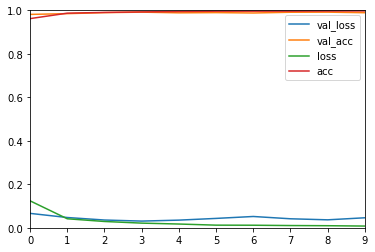

In [33]:
historydf = pd.DataFrame(training.history, index=training.epoch)
historydf.plot(ylim=(0,1))

## STEP 5 : Testing our model

Maintenant que nous avons un modèle, nous allons pouvoir le tester. Pour cela, nous allons créer nos propres images de digits en blanc sur noir en allant sur ce site : https://www.piskelapp.com/
- Cliquer sur *Create Sprite* en haut à droite
- Dans les paramètres, resize l'image à 28x28
- N'oubliez pas de faire un **fond noir**
- Dessinez le digit que vous voulez tester **en blanc** (n'hésitez pas à en faire plusieurs)
- Exportez votre image (icone de la montagne)
- Vérifiez que vous êtes bien sous l'onglet PNG, et cliquez sur *Download Selected frame export*

Ensuite, une fois toutes vos images téléchargées, renommez les avec leur label correspondant (ce sera plus simple de vérifier le résultat), ex : image de 0 sera nommée 0.png
  
Mettez toutes vos images dans le même dossier que votre jupyter notebook
  
Pour aller chercher les images à tester, nous allons utiliser un module appelé **glob** qui se situe déjà dans vos imports.
  
Il faudra ensuite faire les mêmes modifications que nous avons faites à notre dataset dans le *STEP 2 : Prepare dataset* (reshape, normalize)

In [25]:
import numpy as np

In [37]:
# Recupérer toutes nos images
all_images = glob('*.png')
expected = [1, 2, 5, 0, 6, 7]
i = 0;

model = load_model('votre_model.h5')

# Loop in all_images to process each image
for image in all_images :
    # Open the image using cv2
    img = cv2.imread(image, 0)
    
    # Print the image to see (will only print the last one of the loop)
    #plt.imshow(img)
    
    # Reshape the image, adding one dimension at the end
    img = img.reshape(1, 28, 28, 1)
    
    # Recast and normalize
    img = img.astype('float32')
    img /= 255
    
    # Get prediction
    prediction = model.predict(img)
    
    # Get highest value index
    prediction = np.argmax(prediction)
    
    print('The prediction for ', image, 'is :', prediction, '(expected ', expected[i], ')')
    i += 1

The prediction for  New Piskel-1.png.png is : 1 (expected  1 )
The prediction for  New Piskel-2.png.png is : 2 (expected  2 )
The prediction for  New Piskel-3.png.png is : 5 (expected  5 )
The prediction for  New Piskel-4.png.png is : 9 (expected  0 )
The prediction for  New Piskel-5.png.png is : 6 (expected  6 )
The prediction for  New Piskel-6.png.png is : 7 (expected  7 )
